In [1]:
import pandas as pd

df = pd.read_csv('/content/Daily_Demand_Forecasting_Orders.csv', sep=';')

#df=df.drop(columns = ['date'])
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
#df = imputer.fit_transform(df)

'''
df=df.dropna()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le1 = LabelEncoder()
le2 = LabelEncoder()
'''


#df['icon']= le.fit_transform(df['icon'])

y = df['Non-urgent order'].values
df=df.drop(columns = ['Non-urgent order'])
X = df.values


In [2]:

y=y.reshape(-1, 1)


import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [5]:
x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [8]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    #outputs = layers.Dense(5, activation="softmax")(x)
    outputs = layers.Dense(1)(x)


    return keras.Model(inputs, outputs)

In [9]:


input_shape = x_train1.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

'''
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"],
)
'''
model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_absolute_error"],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 13, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 13, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [19]:

model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["mean_absolute_error"],
)

callbacks = [keras.callbacks.EarlyStopping(patience=700, restore_best_weights=True)]

history=model.fit(
    x_train1,
    y_train1,
    validation_data=(x_test1, y_test1),
    epochs=2000,
    batch_size=128,
    callbacks=callbacks,
)


Epoch 1/2000
1/1 [==============================] - 10s 10s/step - loss: 55.9977 - mean_absolute_error: 55.9977 - val_loss: 37.7538 - val_mean_absolute_error: 37.7538
Epoch 2/2000
1/1 [==============================] - 0s 50ms/step - loss: 59.2976 - mean_absolute_error: 59.2976 - val_loss: 45.4762 - val_mean_absolute_error: 45.4762
Epoch 3/2000
1/1 [==============================] - 0s 76ms/step - loss: 65.8235 - mean_absolute_error: 65.8235 - val_loss: 35.2119 - val_mean_absolute_error: 35.2119
Epoch 4/2000
1/1 [==============================] - 0s 50ms/step - loss: 56.4649 - mean_absolute_error: 56.4649 - val_loss: 39.9118 - val_mean_absolute_error: 39.9118
Epoch 5/2000
1/1 [==============================] - 0s 49ms/step - loss: 61.4388 - mean_absolute_error: 61.4388 - val_loss: 42.7565 - val_mean_absolute_error: 42.7565
Epoch 6/2000
1/1 [==============================] - 0s 61ms/step - loss: 59.1698 - mean_absolute_error: 59.1698 - val_loss: 37.8497 - val_mean_absolute_error: 37.849

In [20]:
#testing prediction
ypred=model.predict(x_test1)
#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
#print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))

mse:  1013.9623512350016
mae:  22.26228162638346
r2_score:  0.09995234049525248
explained_variance_score:  0.44609517475920246
max_error:  84.5432412109375
mean_poisson_deviance:  0.09995234049525248


In [21]:
#training prediction
xpred=model.predict(x_train1)
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
#print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  312.9384550773062
mae:  13.274472158878407
r2_score:  0.9293040808182712
explained_variance_score:  0.9296427637091965
max_error:  44.97564404296875
mean_poisson_deviance:  0.9293040808182712


In [22]:
xx=[]
for i in range(len(ypred)):
    xx.append(i)

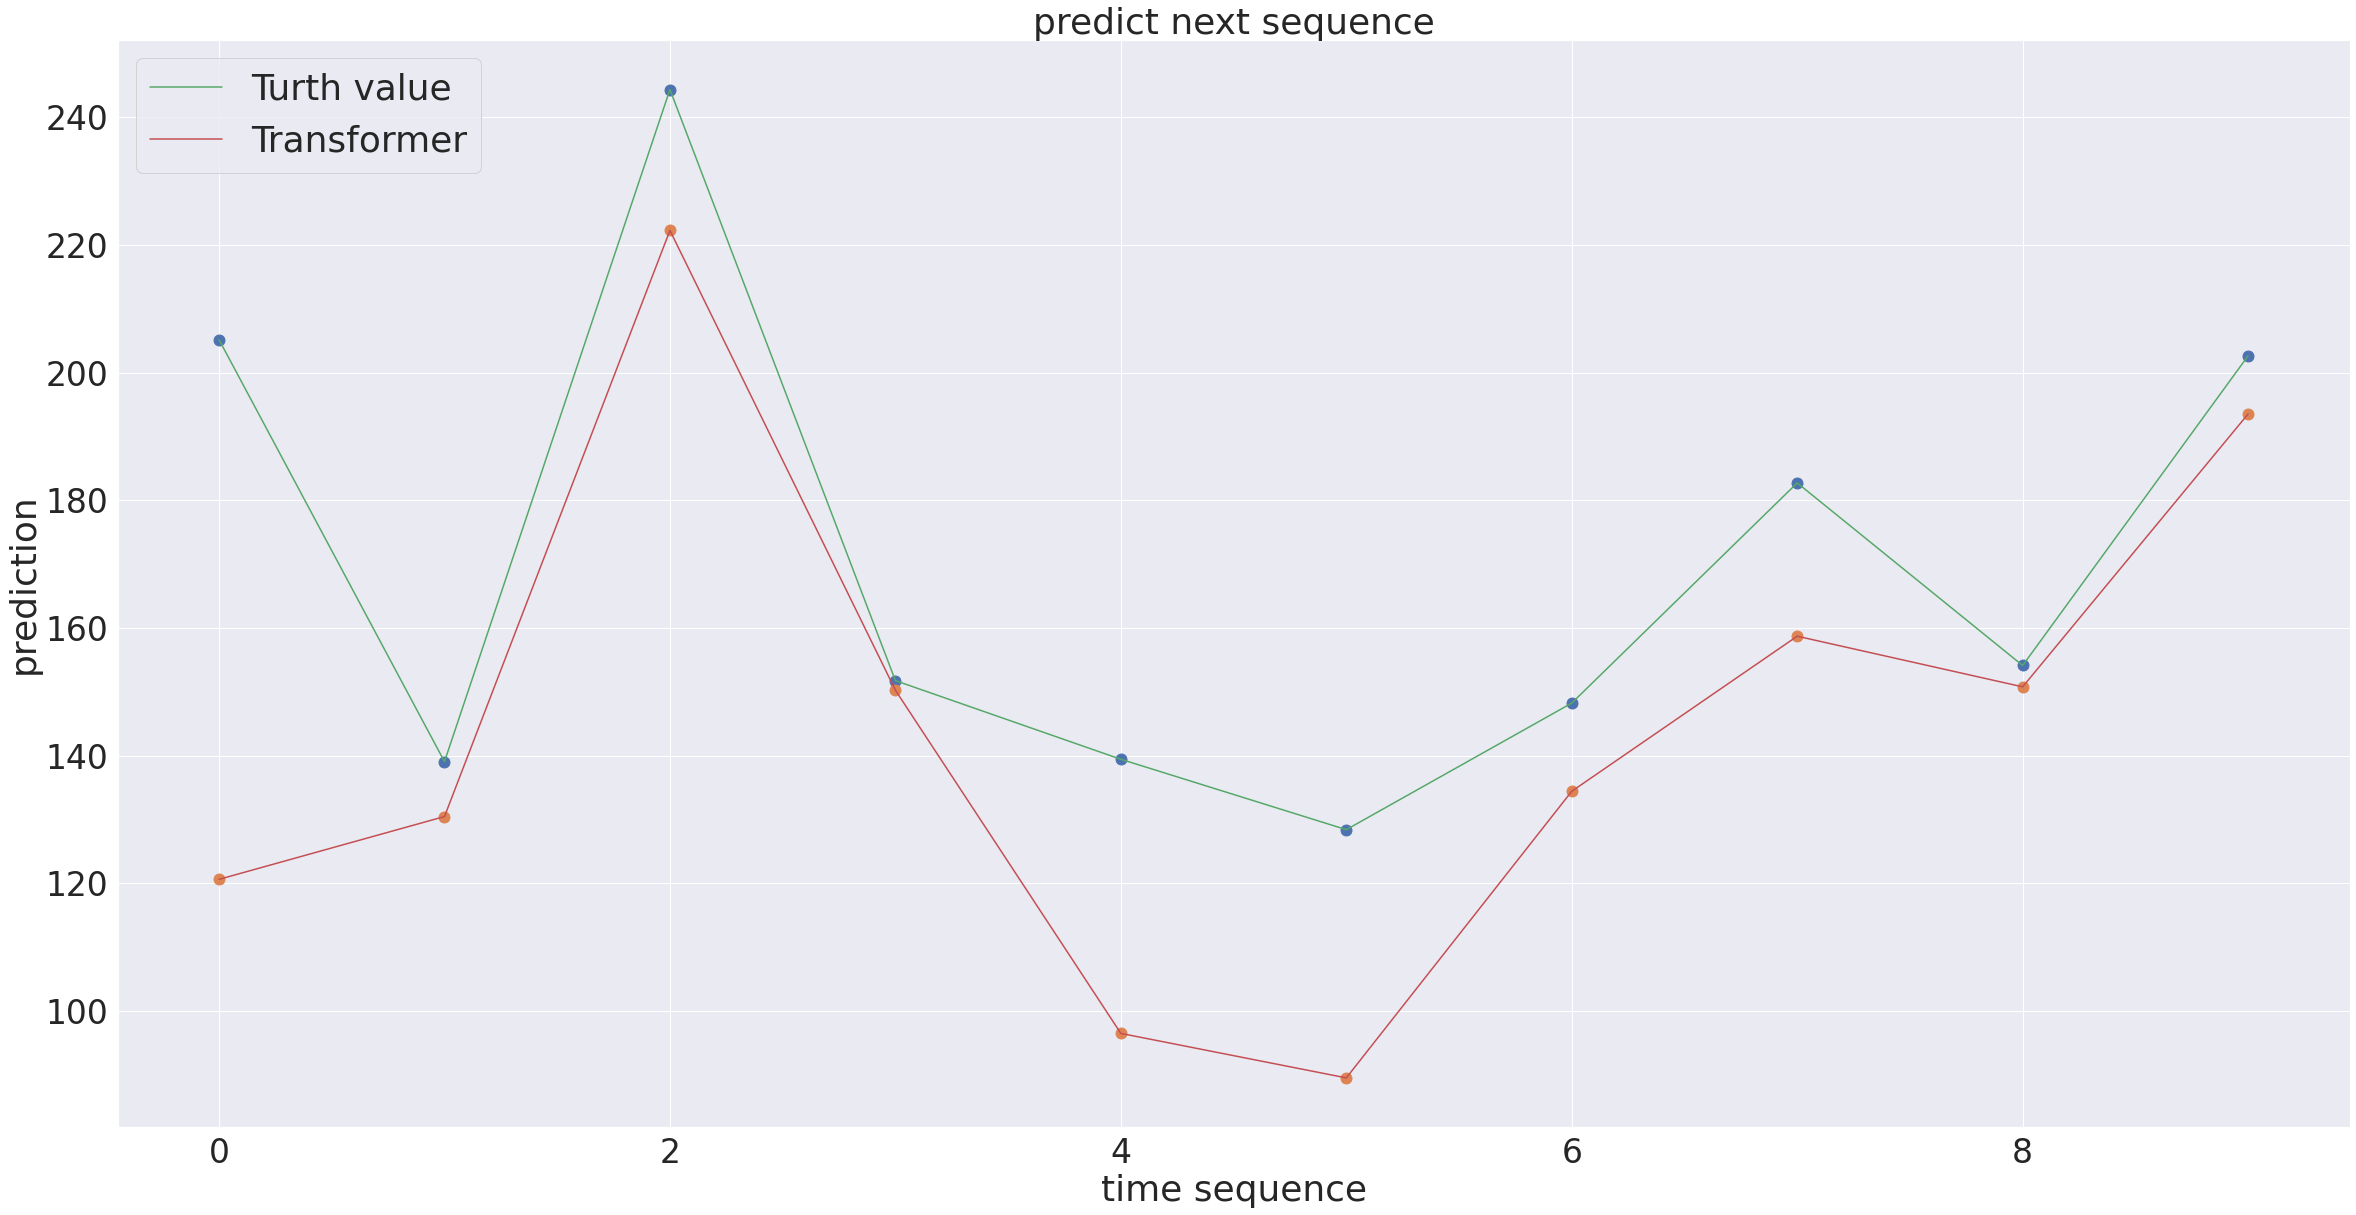

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=10
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='Turth value', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Transformer')

plt.scatter(xx[i:j],ypred[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('prediction', fontsize=36)
plt.show()

In [24]:
import pickle
with open('trans_y_predict.pickle', 'wb') as handle:
    pickle.dump(ypred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
import pickle
with open('trans_x_predict.pickle', 'wb') as handle:
    pickle.dump(xpred, handle, protocol=pickle.HIGHEST_PROTOCOL)